In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import time
import pandas as pd
import plotly.graph_objects as goa
import tensorflow as tf
import warnings

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

## LSTM sur données normalisées

In [3]:
daily_norm_dataFrame = pd.read_table(r'./Data/dataNormalisee.csv', sep = ";", engine = 'python')

In [5]:
data_Open = daily_norm_dataFrame.filter(['Open'])
dataset_Open = data_Open.values

data_Last = daily_norm_dataFrame.filter(['Last'])
dataset_Last = data_Last.values

data_High = daily_norm_dataFrame.filter(['High'])
dataset_High = data_High.values

data_Low = daily_norm_dataFrame.filter(['Low'])
dataset_Low = data_Low.values

In [6]:
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.LSTM(60, input_shape=(60, 1)))
model1.add(tf.keras.layers.Dense(128))
model1.add(tf.keras.layers.Activation('relu'))
model1.add(tf.keras.layers.Dense(1))
model1.compile(loss='mean_absolute_error', metrics=['mean_absolute_error', 'mean_squared_error', 'accuracy'], optimizer='nadam')

In [7]:
def LSTM(data, dataset, model):
    training_data_len = math.ceil(len(dataset) * .9) # I use 80 % of the total dataset for training
    train_data = dataset[0:training_data_len, : ]

    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i,0])
        y_train.append(train_data[i,0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    test_data = dataset[training_data_len - 60: , :]
    x_test = []
    y_test = dataset[training_data_len: , :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i,0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    history = model.fit(x_train, y_train, batch_size=3, epochs=10)

    predictions = model1.predict(x_test)
    
    rmse = math.sqrt(np.mean(predictions - y_test)**2)

    train = data[:training_data_len]
    valid = data[training_data_len:]
    
    valid['Predictions'] = predictions
    return valid,train,rmse, history

In [8]:
valid_Open,train_Open,rmse_Open, hOpen = LSTM(data_Open, dataset_Open, model1)
valid_Last,train_Last,rmse_Last, hLast = LSTM(data_Last, dataset_Last, model1)
valid_High,train_High,rmse_High, hHigh = LSTM(data_High, dataset_High, model1)
valid_Low,train_Low,rmse_Low, hLow = LSTM(data_Low, dataset_Low, model1)

Epoch 1/10
656/656 [==============================] - 65s 20ms/step - loss: 0.0482 - mean_absolute_error: 0.0482 - mean_squared_error: 0.0122 - accuracy: 0.0000e+00
Epoch 2/10
159/656 [======>.......................] - ETA: 10s - loss: 0.0283 - mean_absolute_error: 0.0283 - mean_squared_error: 0.0013 - accuracy: 0.0000e+00

Exception ignored in: <function ScopedTFGraph.__del__ at 0x000002991FE0B790>
Traceback (most recent call last):
  File "C:\Users\trist\anaconda3\envs\tf2.6\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 58, in __del__
    self.deleter(self.graph)
KeyboardInterrupt: 

KeyboardInterrupt



## Visualisation

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Model1')
plt.xlabel('Jour', fontsize=18)
plt.ylabel('Close Price Normalized', fontsize=18)
plt.plot(train_Last['Last'], linewidth=1)
plt.plot(valid_Last[['Last', 'Predictions']], linewidth=1)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
def afficher_predictions(train_Open, train_Last, train_High, train_Low, valid_Open, valid_Last, valid_High,valid_Low, normalisation, df_norm):
    t = list(train_Open['Open'])
    train_Open["Predictions"] = pd.Series(t)
    open_ = pd.concat([train_Open,valid_Open])

    t = list(train_Last['Last'])
    train_Last["Predictions"] = pd.Series(t)
    last_ = pd.concat([train_Last,valid_Last])

    t = list(train_High['High'])
    train_High["Predictions"] = pd.Series(t)
    high_ = pd.concat([train_High,valid_High])

    t = list(train_Low['Low'])
    train_Low["Predictions"] = pd.Series(t)
    low_ = pd.concat([train_Low,valid_Low])
    
    dataFrame_daily = pd.read_table("Data/daily_data.csv", sep = ";", engine = 'python')
    
    df_affichage = df_norm.copy(deep=True)
    df_affichage_predict = df_norm.copy(deep=True)
    
    df_affichage["Open"] =  open_["Open"]
    df_affichage["Last"] =  last_["Last"]
    df_affichage["High"] =  high_["High"]
    df_affichage["Low"] =  low_["Low"]

    df_affichage_predict["Open"] =  open_["Predictions"]
    df_affichage_predict["Last"] =  last_["Predictions"]
    df_affichage_predict["High"] =  high_["Predictions"]
    df_affichage_predict["Low"] =  low_["Predictions"]
    
    %run DeNormaliser.ipynb
    
    if normalisation == "semaine" or normalisation == "semaines":
        denorm = reverseDaily(dataFrame_daily, df_affichage, 30)
        denorm_predict = reverseDaily(dataFrame_daily, df_affichage_predict, 30) 
    elif normalisation == "mois":
        denorm = denorm_month(dataFrame_daily, df_affichage)
        denorm_predict = denorm_month(dataFrame_daily, df_affichage_predict)
    else:
        denorm = denormalisation_min_max(dataFrame_daily, df_affichage)
        denorm_predict = denormalisation_min_max(dataFrame_daily, df_affichage_predict)
    
    return denorm, denorm_predict

In [ ]:
denorm, denorm_predict = afficher_predictions(train_Open, train_Last, train_High, train_Low, "semaine")

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Model1')
plt.xlabel('Jour', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(dernorm_predict['Close'], linewidth=1, color='r', label='Donnees predites')
plt.plot(denorm['Close'], linewidth=1, color='black', label='Donnees initiales')
plt.legend(loc='best')
plt.show()

In [ ]:
nb_jours = 250
plt.figure(figsize=(16,8))
plt.title('Model1')
plt.xlabel('Jour', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(dernorm_predict['Close'][-nb_jours:], linewidth=1, color='r', label='Donnees predites')
plt.plot(denorm['Close'][-nb_jours:], linewidth=1, color='black', label='Donnees initiales')
plt.legend(loc='best')
plt.show()

### Comparer les normalisations

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
MSE_moyenneMobile = []
MAE_moyenneMobile = []
ACC_moyenneMobile = []
for k in range(1, 31):
    df = pd.read_table("./Data/NormalisationMM/dataNormMM_" + str(k) + ".csv", sep = ";", engine = 'python')
    print("NORMALISATION - CAS PROFONDEUR " + str(k))
    data_Open = df.filter(['Open'])
    dataset_Open = data_Open.values

    data_Last = df.filter(['Last'])
    dataset_Last = data_Last.values
    
    data_High = df.filter(['High'])
    dataset_High = data_High.values

    data_Low = df.filter(['Low'])
    dataset_Low = data_Low.values
    
    
    valid_Open,train_Open,rmse_Open, historyOpen = LSTM(data_Open, dataset_Open, model1)
    print()
    valid_Last,train_Last,rmse_Last, historyLast = LSTM(data_Last, dataset_Last, model1)
    print()
    valid_High,train_High,rmse_High, historyHigh = LSTM(data_High, dataset_High, model1)
    print()
    valid_Low,train_Low,rmse_Low, historyLow = LSTM(data_Low, dataset_Low, model1)
    print()
    
    total_rmse = rmse_Open + rmse_Last + rmse_High + rmse_Low
    MSE_moyenneMobile.append(total_rmse)
    
    maeOpen = np.mean(historyOpen.history.get('mean_absolute_error'))
    maeLast = np.mean(historyLast.history.get('mean_absolute_error'))
    maeHigh = np.mean(historyHigh.history.get('mean_absolute_error'))
    maeLow = np.mean(historyLow.history.get('mean_absolute_error'))
    total_mae = maeOpen + maeLast + maeHigh + maeLow
    MAE_moyenneMobile.append(total_mae)
    
    accOpen = np.mean(historyOpen.history.get('accuracy'))
    accLast = np.mean(historyLast.history.get('accuracy'))
    accHigh = np.mean(historyHigh.history.get('accuracy'))
    accLow = np.mean(historyLow.history.get('accuracy'))
    total_acc = accOpen + accLast + accHigh + accLow
    ACC_moyenneMobile.append(total_acc)

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.plot(range(1, 31), MSE_moyenneMobile, label='MSE', color='red')
plt.plot(range(1, 31), MAE_moyenneMobile, label='MAE', color='black')
plt.legend(loc='best')
plt.xlabel('Profondeur de la moyenne mobile')
plt.ylabel('Valeur des variables')
plt.title('Evolution des metriques en fonction de la profondeur de la moyenne mobile de la normalisation\n', fontsize=16)
plt.show()

## Comparer différents types de normalisation

In [ ]:
df = pd.read_table("./Data/NormalisationMM/dataNormMM_30.csv", sep = ";", engine = 'python')
data_Open = df.filter(['Open'])
dataset_Open = data_Open.values

data_Last = df.filter(['Last'])
dataset_Last = data_Last.values
    
data_High = df.filter(['High'])
dataset_High = data_High.values

data_Low = df.filter(['Low'])
dataset_Low = data_Low.values
    
    
valid_Open,train_Open,rmse_Open, historyOpen = LSTM(data_Open, dataset_Open, model1)
print()
valid_Last,train_Last,rmse_Last, historyLast = LSTM(data_Last, dataset_Last, model1)
print()
valid_High,train_High,rmse_High, historyHigh = LSTM(data_High, dataset_High, model1)
print()
valid_Low,train_Low,rmse_Low, historyLow = LSTM(data_Low, dataset_Low, model1)
print()
    
mseOpen = np.mean(historyOpen.history.get('mean_squared_error'))
mseLast = np.mean(historyLast.history.get('mean_squared_error'))
mseHigh = np.mean(historyHigh.history.get('mean_squared_error'))
mseLow = np.mean(historyLow.history.get('mean_squared_error'))
MSE_MM = mseOpen + mseLast + mseHigh + mseLow
    
maeOpen = np.mean(historyOpen.history.get('mean_absolute_error'))
maeLast = np.mean(historyLast.history.get('mean_absolute_error'))
maeHigh = np.mean(historyHigh.history.get('mean_absolute_error'))
maeLow = np.mean(historyLow.history.get('mean_absolute_error'))
MAE_MM = maeOpen + maeLast + maeHigh + maeLow
    
accOpen = np.mean(historyOpen.history.get('accuracy'))
accLast = np.mean(historyLast.history.get('accuracy'))
accHigh = np.mean(historyHigh.history.get('accuracy'))
accLow = np.mean(historyLow.history.get('accuracy'))
ACC_MM = accOpen + accLast + accHigh + accLow

In [28]:
df = pd.read_table("./Data/dataMinMaxNormalisee.csv", sep = ";", engine = 'python')
data_Open = df.filter(['Open'])
dataset_Open = data_Open.values

data_Last = df.filter(['Last'])
dataset_Last = data_Last.values
    
data_High = df.filter(['High'])
dataset_High = data_High.values

data_Low = df.filter(['Low'])
dataset_Low = data_Low.values
    
    
valid_Open,train_Open,rmse_Open, historyOpen = LSTM(data_Open, dataset_Open, model1)
print()
valid_Last,train_Last,rmse_Last, historyLast = LSTM(data_Last, dataset_Last, model1)
print()
valid_High,train_High,rmse_High, historyHigh = LSTM(data_High, dataset_High, model1)
print()
valid_Low,train_Low,rmse_Low, historyLow = LSTM(data_Low, dataset_Low, model1)
print()
    
mseOpen = np.mean(historyOpen.history.get('mean_squared_error'))
mseLast = np.mean(historyLast.history.get('mean_squared_error'))
mseHigh = np.mean(historyHigh.history.get('mean_squared_error'))
mseLow = np.mean(historyLow.history.get('mean_squared_error'))
MSE_MinMax = mseOpen + mseLast + mseHigh + mseLow
    
maeOpen = np.mean(historyOpen.history.get('mean_absolute_error'))
maeLast = np.mean(historyLast.history.get('mean_absolute_error'))
maeHigh = np.mean(historyHigh.history.get('mean_absolute_error'))
maeLow = np.mean(historyLow.history.get('mean_absolute_error'))
MAE_MinMax = maeOpen + maeLast + maeHigh + maeLow
    
accOpen = np.mean(historyOpen.history.get('accuracy'))
accLast = np.mean(historyLast.history.get('accuracy'))
accHigh = np.mean(historyHigh.history.get('accuracy'))
accLow = np.mean(historyLow.history.get('accuracy'))
ACC_MinMax = accOpen + accLast + accHigh + accLow

Epoch 1/10
669/669 [==============================] - 8s 11ms/step - loss: 0.0124 - mean_absolute_error: 0.0124 - mean_squared_error: 4.1560e-04 - accuracy: 0.0000e+00
Epoch 2/10
669/669 [==============================] - 8s 12ms/step - loss: 0.0116 - mean_absolute_error: 0.0116 - mean_squared_error: 2.6124e-04 - accuracy: 0.0000e+00
Epoch 3/10
669/669 [==============================] - 8s 11ms/step - loss: 0.0116 - mean_absolute_error: 0.0116 - mean_squared_error: 2.5762e-04 - accuracy: 0.0000e+00: 0s - loss: 0.0116 - mean_absolute_error: 0.0116 - mean_squared_error: 2.5639e-04 - accu
Epoch 4/10
669/669 [==============================] - 8s 12ms/step - loss: 0.0115 - mean_absolute_error: 0.0115 - mean_squared_error: 2.5545e-04 - accuracy: 0.0000e+00
Epoch 5/10
669/669 [==============================] - 8s 12ms/step - loss: 0.0119 - mean_absolute_error: 0.0119 - mean_squared_error: 2.6818e-04 - accuracy: 0.0000e+00
Epoch 6/10
669/669 [==============================] - 8s 12ms/step - lo

In [29]:
df = pd.read_table("./Data/dataMonthNormalisee.csv", sep = ";", engine = 'python')
data_Open = df.filter(['Open'])
dataset_Open = data_Open.values

data_Last = df.filter(['Last'])
dataset_Last = data_Last.values
    
data_High = df.filter(['High'])
dataset_High = data_High.values

data_Low = df.filter(['Low'])
dataset_Low = data_Low.values
    
    
valid_Open,train_Open,rmse_Open, historyOpen = LSTM(data_Open, dataset_Open, model1)
print()
valid_Last,train_Last,rmse_Last, historyLast = LSTM(data_Last, dataset_Last, model1)
print()
valid_High,train_High,rmse_High, historyHigh = LSTM(data_High, dataset_High, model1)
print()
valid_Low,train_Low,rmse_Low, historyLow = LSTM(data_Low, dataset_Low, model1)
print()
    
mseOpen = np.mean(historyOpen.history.get('mean_squared_error'))
mseLast = np.mean(historyLast.history.get('mean_squared_error'))
mseHigh = np.mean(historyHigh.history.get('mean_squared_error'))
mseLow = np.mean(historyLow.history.get('mean_squared_error'))
MSE_Month = mseOpen + mseLast + mseHigh + mseLow
    
maeOpen = np.mean(historyOpen.history.get('mean_absolute_error'))
maeLast = np.mean(historyLast.history.get('mean_absolute_error'))
maeHigh = np.mean(historyHigh.history.get('mean_absolute_error'))
maeLow = np.mean(historyLow.history.get('mean_absolute_error'))
MAE_Month = maeOpen + maeLast + maeHigh + maeLow
    
accOpen = np.mean(historyOpen.history.get('accuracy'))
accLast = np.mean(historyLast.history.get('accuracy'))
accHigh = np.mean(historyHigh.history.get('accuracy'))
accLow = np.mean(historyLow.history.get('accuracy'))
ACC_Month = accOpen + accLast + accHigh + accLow

Epoch 1/10
662/662 [==============================] - 7s 10ms/step - loss: 0.0114 - mean_absolute_error: 0.0114 - mean_squared_error: 2.8626e-04 - accuracy: 0.0000e+00
Epoch 2/10
662/662 [==============================] - 7s 10ms/step - loss: 0.0108 - mean_absolute_error: 0.0108 - mean_squared_error: 2.6586e-04 - accuracy: 0.0000e+00
Epoch 3/10
662/662 [==============================] - 7s 10ms/step - loss: 0.0108 - mean_absolute_error: 0.0108 - mean_squared_error: 2.6980e-04 - accuracy: 0.0000e+00: 5s - loss: 0.0122 - me - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0109 - mean_squared_error: 2.6577
Epoch 4/10
662/662 [==============================] - 7s 10ms/step - loss: 0.0108 - mean_absolute_error: 0.0108 - mean_squared_error: 2.6370e-04 - accuracy: 0.0000e+00
Epoch 5/10
662/662 [==============================] - 7s 10ms/step - loss: 0.0106 - mean_absolute_error: 0.0106 - mean_squared_error: 2.5730e-04 - accuracy: 0.0000e+00
Epoch 6/10
662/662 [==============================] 

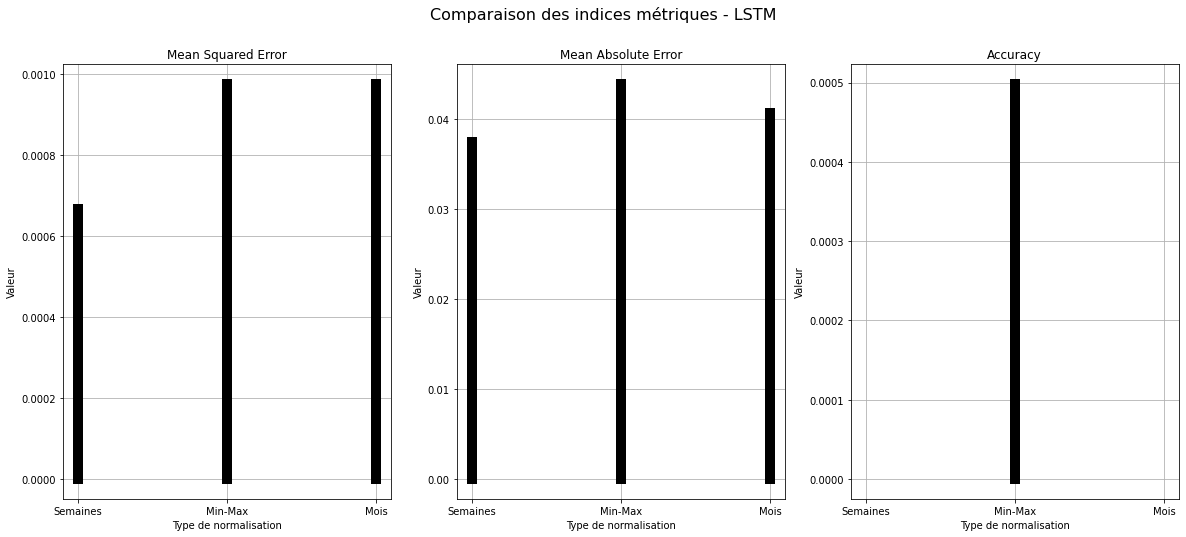

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle('Comparaison des indices métriques - LSTM\n', fontsize=16)

axs[0].plot([0, 0], [0, MSE_MM], linewidth = 10, c='black')
axs[0].plot([1, 1], [0, MSE_MinMax], linewidth = 10, c='black')
axs[0].plot([2, 2], [0, MSE_Month], linewidth = 10, c='black')

axs[1].plot([0, 0], [0, MAE_MM], linewidth = 10, c='black')
axs[1].plot([1, 1], [0, MAE_MinMax], linewidth = 10, c='black')
axs[1].plot([2, 2], [0, MAE_Month], linewidth = 10, c='black')

axs[2].plot([0, 0], [0, ACC_MM], linewidth = 10, c='black')
axs[2].plot([1, 1], [0, ACC_MinMax], linewidth = 10, c='black')
axs[2].plot([2, 2], [0, ACC_Month], linewidth = 10, c='black')


for j in range(3):
    axs[j].grid()
    axs[j].set_xticks([0, 1, 2],['Semaines','Min-Max','Mois'])
    axs[j].set_xlabel('Type de normalisation')
    axs[j].set_ylabel("Valeur")
    
axs[0].set_title('Mean Squared Error')
axs[1].set_title('Mean Absolute Error')
axs[2].set_title('Accuracy')
    
plt.show()

### LSTM sur Normalisation par semaines - profondeur 30

In [97]:
dataFrame_daily = pd.read_table("Data/daily_data.csv", sep = ";", engine = 'python')

In [98]:
import warnings
warnings.filterwarnings('ignore')

In [99]:
df = pd.read_table("./Data/NormalisationMM/dataNormMM_30.csv", sep = ";", engine = 'python')

data_Open = df.filter(['Open'])
dataset_Open = data_Open.values

data_Last = df.filter(['Last'])
dataset_Last = data_Last.values
    
data_High = df.filter(['High'])
dataset_High = data_High.values

data_Low = df.filter(['Low'])
dataset_Low = data_Low.values
    
    
valid_Open,train_Open,rmse_Open, historyOpen = LSTM(data_Open, dataset_Open, model1)
print()
valid_Last,train_Last,rmse_Last, historyLast = LSTM(data_Last, dataset_Last, model1)
print()
valid_High,train_High,rmse_High, historyHigh = LSTM(data_High, dataset_High, model1)
print()
valid_Low,train_Low,rmse_Low, historyLow = LSTM(data_Low, dataset_Low, model1)
print()

Epoch 1/10
644/644 [==============================] - 8s 12ms/step - loss: 0.0105 - mean_absolute_error: 0.0105 - mean_squared_error: 1.9755e-04 - accuracy: 0.0000e+00
Epoch 2/10
644/644 [==============================] - 8s 12ms/step - loss: 0.0102 - mean_absolute_error: 0.0102 - mean_squared_error: 1.8892e-04 - accuracy: 0.0000e+00
Epoch 3/10
644/644 [==============================] - 8s 12ms/step - loss: 0.0104 - mean_absolute_error: 0.0104 - mean_squared_error: 1.9395e-04 - accuracy: 0.0000e+00
Epoch 4/10
644/644 [==============================] - 8s 12ms/step - loss: 0.0102 - mean_absolute_error: 0.0102 - mean_squared_error: 1.8780e-04 - accuracy: 0.0000e+00
Epoch 5/10
644/644 [==============================] - 8s 12ms/step - loss: 0.0106 - mean_absolute_error: 0.0106 - mean_squared_error: 1.9991e-04 - accuracy: 0.0000e+00
Epoch 6/10
644/644 [==============================] - 8s 12ms/step - loss: 0.0103 - mean_absolute_error: 0.0103 - mean_squared_error: 1.9040e-04 - accuracy: 0.0

In [104]:
denorm_semaine, denorm_semaine_predict = afficher_predictions(train_Open, train_Last, train_High, train_Low, valid_Open, valid_Last, valid_High, valid_Low, "semaine", df)

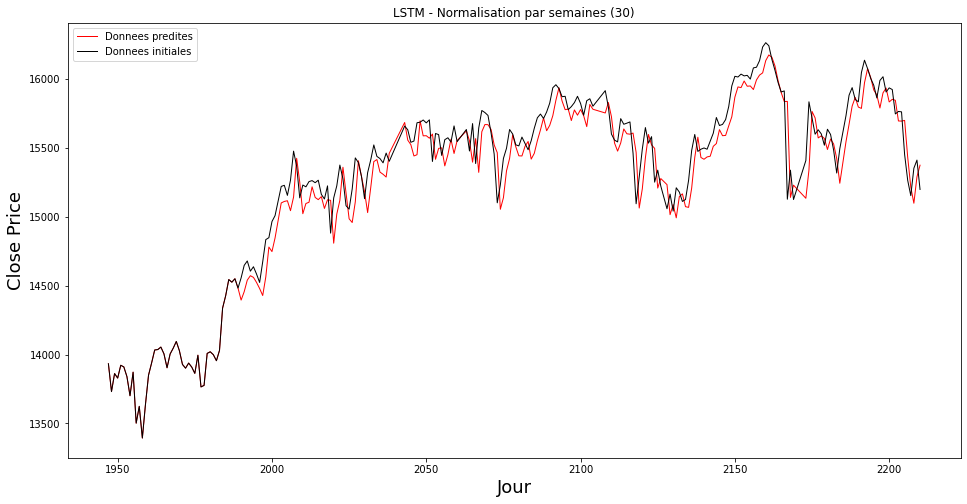

In [106]:
nb_jours = 250
plt.figure(figsize=(16,8))
plt.title('LSTM - Normalisation par semaines (30)')
plt.xlabel('Jour', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(denorm_semaine_predict['Close'][-nb_jours:], linewidth=1, color='r', label='Donnees predites')
plt.plot(denorm_semaine['Close'][-nb_jours:], linewidth=1, color='black', label='Donnees initiales')
plt.legend(loc='best')
plt.show()